<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

# Decoder Causal Language Models

Estimated time needed: **45** minutes

In this tutorial, you'll learn how to build and train a decoder GPT-like model, which is great for generating text and other natural language processing tasks. We'll start with the basics, like getting our environment ready and preparing our data by breaking it down into tokens and turning those tokens into numbers the model can understand. Then, we'll dive into building the model itself, focusing on how it learns to pay attention to different parts of the text to generate text. Along the way, we'll cover how to train our model with data. Finally, we'll see how to use our trained model to create text based on what it has learned.

## GPT models

GPT (Generative Pretrained Transformer) is a decoder-only model because it is trained using a causal language modeling objective, where the goal is to predict the next token in a sequence given the previous tokens. During training, the input sequence is shifted to the right, and the model learns to generate output tokens autoregressively, one at a time. This process allows GPT to generate coherent and contextually relevant text based on the given input prompt. In this lab you will learn how to create and train a decoder-only GPT-like model. However, please note that the actual GPT models are larger models and are trained on massive training data for specific NLP tasks.

## GPT vs. ChatGPT

GPT and ChatGPT are both AI models developed by OpenAI, but they serve different purposes and have distinct functionalities.

GPT is a family of large-scale transformer-based language models trained on diverse internet text data. GPT models are designed for a wide range of natural language processing tasks, such as text generation, translation, summarization, and question-answering. They generate responses based on the input text (prompt) but do not maintain a consistent conversation history.

On the other hand, ChatGPT is a fine-tuned version of the GPT model, specifically designed for conversational AI applications. It is trained to maintain a consistent conversation history and generate contextually relevant responses, making it more suitable for chatbot-like interactions. ChatGPT excels at understanding and generating human-like dialogues, providing coherent and engaging responses in a conversational setting.


## __Table of contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Text-pipeline">Text pipeline</a>
        <ol>
            <li><a href="#Dataset">Dataset</a></li>
            <li> <a href="#Collate-function">Collate function</a></li> 
        </ol>
    </li>
    <li><a href="#Model-prerequisites">Model prerequisites</a>
        <ol>
            <li><a href="#Masking">Masking</a></li>
            <li><a href="#Positional-encoding">Positional encoding</a></li>
            <li><a href="#Token-embedding">Token embedding</a></li>
        </ol>
    </li>
    <li>
        <a href="#Custom-GPT-model-architecture">Custom GPT model architecture</a>
        <ol>
            <li><a href="#Model-configuration-and-initialization">Model configuration and initialization</a></li>
            <li><a href="#Iterating-through-data-samples">Iterating through data samples</a></li>
        </ol>
    </li>
    <li>
        <a href="#Full-output">Full output</a>
        <ol>
            <li><a href="#Decoding-the-differences:-Training-vs.-inference">Decoding the differences: Training vs. inference</a></li>
            <li><a href="#Training-the-model">Training the model</a></li>
            <li><a href="#Loading-the-saved-model">Loading the saved model</a></li>
            <li><a href="#Loading-GPT2-model-from-HuggingFace">Loading GPT2 model from HuggingFace</a></li>
        </ol>
    </li>
      <li>
        <a href="#Exercise:-Creating-a-decoder-model">Exercise: Creating a decoder model</a>
    </li>
</ol>


## Objectives

After going through this tutorial, you'll be able to:

- Understand how to pick random samples from your data and break text down into tokens.
- Learn how to turn tokens into a vocabulary that your model can use to understand and process text.
- Master the setup of the decoder model architecture, including how it uses attention to generate text.
- Get familiar with training a decoder model, including how to feed it data and improve its performance over time.
- Use your trained decoder model to generate text.


## Setup


### Installing required libraries

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:

```bash
!pip install -U torchdata==0.7.1
!pip install -Uqq portalocker>=2.0.0
!pip install -qq torchtext==0.17.1
!pip install -qq matplotlib
!pip install -qq transformers
```

- **torchdata**: Enhances data loading and preprocessing functionalities for PyTorch, streamlining the workflow for machine learning models.
- **portalocker**: Provides a mechanism to lock files, ensuring that only one process can access a file at a time, useful for managing file resources in concurrent applications.
- **torchtext**: Offers utilities for text processing and datasets in PyTorch, simplifying the preparation of data for NLP tasks.
- **matplotlib**: A plotting library for creating static, interactive, and animated visualizations in Python, commonly used for data visualization and graphical plotting tasks.

Each of these libraries is used to handle different aspects of data preparation, processing, and model training for machine learning and natural language processing applications, enhancing the overall workflow and capabilities of the project.


In [1]:
import os

import math
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset
from typing import Iterable, List


from torch import Tensor
from torch.nn import Transformer
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from torchtext.datasets import IMDB,PennTreebank

from transformers import GPT2Tokenizer, GPT2LMHeadModel

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

print("Import Successfully!")

True
Tesla P40
Import Successfully!


# Text pipeline
## Dataset
The code loads the IMDB dataset into training, and validation sets. It then creates an iterator for the training set and loops through the first 10 samples, printing each one. This process simulates how one might manually iterate over a dataset without using PyTorch's `DataLoader` for batch processing and data management.

When training language models, it is generally advisable to use general-domain text. However, in this case, we are using the IMDB dataset, which is well-suited for classification tasks. However, we use IMDB due to its smaller size and compatibility with machines that have limited RAM. For language modeling tasks, some datasets you can consider include: [PennTreebank](https://pytorch.org/text/0.8.1/datasets.html#penntreebank), [WikiText-2](https://pytorch.org/text/0.8.1/datasets.html#wikitext-2), [WikiText103](https://pytorch.org/text/0.8.1/datasets.html#wikitext103)



In [2]:
# Load the dataset
# train_iter, val_iter = IMDB()

# Load IMDB dataset
dataset = load_dataset('imdb')

# Access the train and test splits
train_iter = dataset['train']
val_iter = dataset['test']

# Example: Print the first example
print(train_iter[0])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

Initialize an iterator for the train data loader:


In [3]:
# # retriving the third first record
# data_itr = iter(train_iter)
# next(data_itr)
# next(data_itr)
# next(data_itr)

Let's define our device (CPU or GPU) for training. We'll check if a GPU is available and use it; otherwise, we'll use the CPU.


In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')


## Preprocessing data
The provided code is used for preprocessing text data, particularly for NLP tasks, with a focus on tokenization and vocabulary building.

- **Special Symbols and Indices**: Initializes special tokens (`<unk>`, `<pad>`, and an empty string for EOS) with their corresponding indices (`0`, `1`, and `2`). These tokens are used for unknown words, padding, and end of sentence respectively.
    - `UNK_IDX`: Index for unknown words.
    - `PAD_IDX`: Index used for padding shorter sentences in a batch to ensure uniform length.
    - `EOS_IDX`: Index representing the end of a sentence (though not explicitly used here as the EOS symbol is set to an empty string).

- **`yield_tokens` Function**: A generator function that iterates through a dataset (`data_iter`), tokenizing each data sample using a `tokenizer` function, and yields one tokenized sample at a time.

- **Vocabulary building**: Constructs a vocabulary from the tokenized dataset. The `build_vocab_from_iterator` function processes tokens generated by `yield_tokens`, includes special tokens (`special_symbols`) at the beginning of the vocabulary, and sets a minimum frequency (`min_freq=1`) for tokens to be included.

- **Default index for unknown tokens**: Sets a default index for tokens not found in the vocabulary (`UNK_IDX`), ensuring that out-of-vocabulary words are handled as unknown tokens.

- **`text_to_index` function**: Converts a given text into a sequence of indices based on the built vocabulary. This function is essential for transforming raw text into a numerical format that can be processed by machine learning models.

- **`index_to_en` function**: Transforms a sequence of indices back into a readable string. It's useful for interpreting the outputs of models and converting numerical predictions back into text.

- **Check functionality**: Demonstrates the use of `index_to_en` by converting a tensor of indices `[0,1,2]` back into their corresponding special symbols. This helps verify that the vocabulary and index conversion functions are working as expected.


In [5]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<|endoftext|>' ]

In [6]:
tokenizer = get_tokenizer('basic_english')

In [7]:
# Function to yield tokens from the dataset
def yield_tokens(data_iter):
    for example in data_iter:
        # Tokenize the text field (IMDB reviews are in the 'text' column)
        yield tokenizer(example['text'])

In [8]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=special_symbols, special_first=True)
vocab.set_default_index(UNK_IDX)

In [9]:
# Print vocabulary size and some tokens
print("Vocabulary size:", len(vocab))
print("First 10 tokens:", list(vocab.get_stoi().items())[:10])

Vocabulary size: 100685
First 10 tokens: [('₤250', 100684), ('₤100', 100683), ('“you’ve', 100681), ('“x”', 100680), ('“sanatorium”', 100679), ('“playboy”', 100678), ('“mr', 100675), ('“jean', 100672), ('“it’s', 100670), ('“him”', 100669)]


In [10]:
# Example: Convert a sample text into token IDs
sample_text = "This is an amazing movie!"
token_ids = [vocab[token] for token in tokenizer(sample_text)]  # Use vocab to convert tokens to ids
print("Token IDs for sample text:", token_ids)

Token IDs for sample text: [15, 11, 42, 477, 22, 37]


>Note : **The above block should be complete in less than 20 seconds.If it takes longer than that, it is advisable to `Restart the kernel` and run the cells following the cell containing the `pip install` commands to ensure that the function mentioned above operates as intended.**


###  Text to index and index to Text


In [11]:
text_to_index=lambda text: [vocab(token) for token in tokenizer(text)]
index_to_en = lambda seq_en: " ".join([vocab.get_itos()[index] for index in seq_en])

In [12]:
#check
index_to_en(torch.tensor([0,1,2]))

'<unk> <pad> <|endoftext|>'

### Collate function
In the context of our decoder model, we aim to create a collate function. This function takes a block of text as input and produces a modified block of text as output. The actual text transformation is achieved through the use of the `get_sample(block_size, text)` function. The **get_sample** function generates a random text sample(src_sequence) and its subsequent sequence(tgt_sequence) from a given text for language model training. It ensures the sample fits within the specified block size and adjusts for text shorter than the block size, returning both the source and target sequences for model input.


In [13]:
def get_sample(block_size, text):
    # Determine the length of the input text
    sample_leg = len(text)
    # Calculate the stopping point for randomly selecting a sample
    # This ensures the selected sample doesn't exceed the text length
    random_sample_stop = sample_leg - block_size


    # Check if a random sample can be taken (if the text is longer than block_size)
    if random_sample_stop >= 1:
        # Randomly select a starting point for the sample
        random_start = torch.randint(low=0, high=random_sample_stop, size=(1,)).item()
        # Define the endpoint of the sample
        stop = random_start + block_size

        # Create the input and target sequences
        src_sequence = text[random_start:stop]
        tgt_sequence= text[random_start + 1:stop + 1]

    # Handle the case where the text length is exactly equal or less the block size
    elif random_sample_stop <= 0:
        # Start from the beginning and use the entire text
        random_start = 0
        stop = sample_leg
        src_sequence= text[random_start:stop]
        tgt_sequence = text[random_start + 1:stop]
        # Append an empty string to maintain sequence alignment
        tgt_sequence.append( '<|endoftext|>')

    return src_sequence, tgt_sequence

Lets test `get_sample(block_size, text)` first and get batch of texts:


In [14]:
BATCH_SIZE=1

batch_of_tokens=[]

for i in range(BATCH_SIZE):
    example =next(iter(train_iter))
    text = example['text']
    batch_of_tokens.append(tokenizer(text))

Get first smaple of text


In [15]:
text=batch_of_tokens[0][0:100]
text[0:100]
batch_of_tokens

[['i',
  'rented',
  'i',
  'am',
  'curious-yellow',
  'from',
  'my',
  'video',
  'store',
  'because',
  'of',
  'all',
  'the',
  'controversy',
  'that',
  'surrounded',
  'it',
  'when',
  'it',
  'was',
  'first',
  'released',
  'in',
  '1967',
  '.',
  'i',
  'also',
  'heard',
  'that',
  'at',
  'first',
  'it',
  'was',
  'seized',
  'by',
  'u',
  '.',
  's',
  '.',
  'customs',
  'if',
  'it',
  'ever',
  'tried',
  'to',
  'enter',
  'this',
  'country',
  ',',
  'therefore',
  'being',
  'a',
  'fan',
  'of',
  'films',
  'considered',
  'controversial',
  'i',
  'really',
  'had',
  'to',
  'see',
  'this',
  'for',
  'myself',
  '.',
  'the',
  'plot',
  'is',
  'centered',
  'around',
  'a',
  'young',
  'swedish',
  'drama',
  'student',
  'named',
  'lena',
  'who',
  'wants',
  'to',
  'learn',
  'everything',
  'she',
  'can',
  'about',
  'life',
  '.',
  'in',
  'particular',
  'she',
  'wants',
  'to',
  'focus',
  'her',
  'attentions',
  'to',
  'making',
 

To test the get_sample function with a block size of 100, where the output includes both the source sequence and the target sequence, with the target sequence being the source sequence shifted by one character, you can use the following code as an example:


In [16]:
block_size=10
src_sequences, tgt_sequence=get_sample( block_size, text)

Check if seqence is shiffted


In [17]:
print("src: ",src_sequences)
print("tgt: ",tgt_sequence)

src:  ['surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.']
tgt:  ['it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i']


The below code creates batches of source (`src_batch`) and target (`tgt_batch`) sequences from a dataset for training NLP models. It loops through the dataset to extract text samples, generates corresponding source and target sequences using the `get_sample` function, converts them into vocabulary indices, and then into PyTorch tensors. Each iteration appends these sequences to their respective batch lists and prints their details, including text, indices, and tensor shapes, for two samples per batch.


In [18]:
# Initialize empty lists to store source and target sequences
src_batch, tgt_batch = [], []

# Define the batch size
BATCH_SIZE = 2

# Loop to create batches of source and target sequences
for i in range(BATCH_SIZE):
    # Retrieve the next data point from the training iterator
    example = next(iter(train_iter))
    text = example['text']
    # Generate source and target sequences using the get_sample function
    src_sequence_text, tgt_sequence_text = get_sample(block_size, tokenizer(text))

    # Convert source and target sequences to tokenized vocabulary indices
    src_sequence_indices = vocab(src_sequence_text)
    tgt_sequence_indices = vocab(tgt_sequence_text)

    # Convert the sequences to PyTorch tensors with dtype int64
    src_sequence = torch.tensor(src_sequence_indices, dtype=torch.int64)
    tgt_sequence = torch.tensor(tgt_sequence_indices, dtype=torch.int64)

    # Append the source and target sequences to their respective batches
    src_batch.append(src_sequence)
    tgt_batch.append(tgt_sequence)

    # Print the output for every 2nd sample (adjust as needed)
    print(f"Sample {i}:")
    print("Source Sequence (Text):", src_sequence_text)
    print("Source Sequence (Indices):", src_sequence_indices)
    print("Source Sequence (Shape):", src_sequence.shape)
    print("Target Sequence (Text):", tgt_sequence_text)
    print("Target Sequence (Indices):", tgt_sequence_indices)
    print("Target Sequence (Shape):", tgt_sequence.shape)

Sample 0:
Source Sequence (Text): ['rented', 'i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of']
Source Sequence (Indices): [1569, 14, 247, 35469, 44, 65, 399, 1136, 93, 8]
Source Sequence (Shape): torch.Size([10])
Target Sequence (Text): ['i', 'am', 'curious-yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all']
Target Sequence (Indices): [14, 247, 35469, 44, 65, 399, 1136, 93, 8, 38]
Target Sequence (Shape): torch.Size([10])
Sample 1:
Source Sequence (Text): ['if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore']
Source Sequence (Indices): [52, 12, 132, 781, 9, 2481, 15, 683, 5, 1576]
Source Sequence (Shape): torch.Size([10])
Target Sequence (Text): ['it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore', 'being']
Target Sequence (Indices): [12, 132, 781, 9, 2481, 15, 683, 5, 1576, 119]
Target Sequence (Shape): torch.Size([10])


The `collate_batch` function prepares batches of source and target sequences for training by processing each text sample in a given batch. It generates source and target sequences using the `get_sample` function with a specified block size, converts these sequences to indices using a vocabulary, and transforms them into PyTorch tensors. The sequences are then padded to ensure uniform length across the batch. Finally, it returns the padded source and target batches, ready for training on the specified device (`DEVICE`).


In [19]:
BLOCK_SIZE=30
def collate_batch(batch):
    src_batch, tgt_batch = [], []
    for example in batch:
        _textt = example['text']
        src_sequence,tgt_sequence=get_sample(BLOCK_SIZE,tokenizer(_textt))
        src_sequence=vocab(src_sequence)
        tgt_sequence=vocab(tgt_sequence)
        src_sequence= torch.tensor(src_sequence, dtype=torch.int64)
        tgt_sequence = torch.tensor(tgt_sequence, dtype=torch.int64)
        src_batch.append(src_sequence)
        tgt_batch.append(tgt_sequence)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=False)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=False)

    return src_batch.to(DEVICE), tgt_batch.to(DEVICE)

The code sets up data loaders for the training, validation, and testing sets using the `DataLoader` class, with each set utilizing a custom `collate_batch` function for batch processing. The data loaders handle batches of size 1 for simplicity and shuffle the data for randomized access. After initializing the training data loader, it fetches the first batch of source (`src`) and target (`tgt`) sequences. It then iterates over each token in the source sequence, converts them back to text using the `index_to_en` function, and prints the resulting sentences, demonstrating how to access and display preprocessed data ready for model training.


In [20]:
BATCH_SIZE=1
dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader= DataLoader(val_iter , batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

### Iterating through data samples

The provided code iterates through batches of source-target pairs from a data loader. It demonstrates how to access and print a few samples from the dataset:

- We initialize an iterator over the data loader named `dataset`.
- A loop runs for 10 iterations to fetch and print the first 10 source-target pairs. For each pair:
    - `src` and `trt` (short for target) hold the batch of source and target sequences respectively.
    - The `index_to_en` function is used to convert these sequences from numerical indices back to readable text.
    - The `sample` number and corresponding source and target texts are printed out.

After printing the first 10 samples, the code continues to iterate through the dataset:

- It prints the shape of the target and source tensors for the next batch, which provides information about the number of tokens and batch size.
- The `index_to_en` function is again used to convert the first sequence of the batch from indices to text for both source and target.
- Only the first pair of the remaining batches is printed, and then the loop breaks.

This process is useful for verifying that the data loader is functioning correctly and that the sequences are being properly transformed.


In [21]:
dataset=iter(dataloader)
for sample in range(10):
  src,trt=next(dataset)
  print("sample",sample)
  print("sorce:",index_to_en(src))
  print("\n")
  print("target:",index_to_en(trt))
  print("\n")

sample 0
sorce: , this film was an interesting experiment in photography . the colors are comic book bold . i think the director got carried away with his artistic vision over the


target: this film was an interesting experiment in photography . the colors are comic book bold . i think the director got carried away with his artistic vision over the look


sample 1
sorce: mexican movie makers are in this film and it ' s not only that the script is terrible . it ' s just that . . . this movie sucks


target: movie makers are in this film and it ' s not only that the script is terrible . it ' s just that . . . this movie sucks .


sample 2
sorce: -- she ' s really flat here and not just in the chest . her role is supposed to be this lively , nice , caring girl who just keeps


target: she ' s really flat here and not just in the chest . her role is supposed to be this lively , nice , caring girl who just keeps getting


sample 3
sorce: movie including the end . when the movie ended , i s

In [22]:
for  src,trt in dataset:
    print(trt.shape)
    print(src.shape)
    print(index_to_en(src[0,:]))
    print(index_to_en(trt[0,:]))
    break

torch.Size([30, 1])
torch.Size([30, 1])
to
the


Make sure source and target is shifted


In [23]:
print("source:",index_to_en(src))
print("target:",index_to_en(trt))

source: to the film by moving on to the dry humour if provides , thankfully of a similar standard to his previous films . bulls**t ! this film doesn ' t
target: the film by moving on to the dry humour if provides , thankfully of a similar standard to his previous films . bulls**t ! this film doesn ' t try


Now that we've covered data preparation, let's move on to understanding the key components of the Transformer model.


## Masking

In transformers, masking is crucial for ensuring certain positions are not attended to. The function ```generate_square_subsequent_mask``` produces an upper triangular matrix, which ensures that during decoding, a token can't attend to future tokens of target.


In [24]:
def generate_square_subsequent_mask(sz,device=DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

The ```create_mask function```, on the other hand, generates source masks, based on the provided source sequence.


In [25]:
def create_mask(src,device=DEVICE):
    src_seq_len = src.shape[0]
    src_mask = generate_square_subsequent_mask(src_seq_len)
    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    return src_mask,src_padding_mask

Let's check an example source tensor and its associated masks:


In [26]:
#Replace first four tokens with PAD token so we can also check how pad tokens are masked using padding_mask
src[0:4]=PAD_IDX

In [27]:
mask,padding_mask = create_mask(src)
src

tensor([[    1],
        [    1],
        [    1],
        [    1],
        [  748],
        [   29],
        [    9],
        [    3],
        [ 2254],
        [ 1248],
        [   52],
        [ 1522],
        [    5],
        [ 2665],
        [    8],
        [    7],
        [  719],
        [ 1282],
        [    9],
        [   33],
        [  932],
        [  115],
        [    4],
        [35008],
        [   37],
        [   15],
        [   24],
        [  160],
        [   10],
        [   28]], device='cuda:0')

In [28]:
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -i

In [29]:
padding_mask

tensor([[ True,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]],
       device='cuda:0')

## Positional encoding
The Transformer model doesn't have built-in knowledge of the order of tokens in the sequence. To give the model this information, positional encodings are added to the embeddings of the tokens. These encodings have a fixed pattern based on their position in the sequence.

GPT uses trainable positional encodings. Unlike fixed positional encodings (such as sinusoidal encodings used in the original Transformer paper), trainable positional encodings are learned during the model training process.

Trainable positional encodings are implemented as a set of learnable parameters, one for each position in the input sequence. These parameters have the same dimensionality as the token embeddings. During training, the model updates the positional encoding parameters along with the other model parameters to capture the positional information more effectively.

The use of trainable positional encodings in GPT allows the model to learn more flexible and task-specific positional representations, potentially improving its performance on various natural language processing tasks.

In the context of this lab, we stick with fixed positional encoding for the sake of simplicity.


In [30]:
# add positional information to the input tokens
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

## Token embedding
Token embedding, also known as word embedding or word representation, is a way to convert words or tokens from a text corpus into numerical vectors in a continuous vector space. Each unique word or token in the corpus is assigned a fixed-length vector where the numerical values represent various linguistic properties of the word, such as its meaning, context, or relationships with other words.

The `TokenEmbedding` class below converts numerical tokens into embeddings:


In [31]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## Custom GPT model architecture

The `CustomGPTModel` class defines a transformer-based model architecture for generative pre-trained models. This model aims to generate text and perform various NLP tasks. Below is an explanation of the main components of the class:

- **Initialization (`__init__`)**: The constructor takes several parameters including `embed_size`, `vocab_size`, `num_heads`, `num_layers`, `max_seq_len`, and `dropout`. It initializes the embedding layer, positional encoding, transformer encoder layers, and a linear layer (`lm_head`) for generating logits over the vocabulary.

- **Weight initialization (`init_weights`)**: This method initializes the weights of the model for better training convergence. The Xavier uniform initialization is used, which is a common practice for initializing weights in deep learning.

- **Decoder (`decoder`)**: Although named `decoder`, this method currently functions as the forward pass through the transformer encoder layers, followed by the generation of logits for the language modeling task. It handles the addition of positional encodings to the embeddings and applies a mask if necessary.

- **Forward pass (`forward`)**: This method is similar to the `decoder` method and defines the forward computation of the model. It processes the input through embedding layers, positional encoding, transformer encoder layers, and produces the final output using the `lm_head`.

- **Mask generation**: Both `decoder` and `forward` methods contain logic to generate a square causal mask if no source mask is provided. This mask ensures that the prediction for a position does not depend on the future tokens in the sequence, which is important for the autoregressive nature of GPT models.

- **Commented out decoder**: A section of the code is commented out, suggesting an initial design where a transformer decoder layer was considered. However, the final implementation uses only encoder layers, which is a common simplification for models focusing on language modeling and generation.

This class effectively encapsulates the necessary components to create a GPT-like model, allowing for training on language modeling tasks and text generation applications.


In [32]:
class CustomGPTModel(nn.Module):
    def __init__(self, embed_size,vocab_size, num_heads, num_layers, max_seq_len=500,dropout=0.1):

        super().__init__()

        self.init_weights()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=dropout)

        print( embed_size )


        # Remaining layers are part of the TransformerDecoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.embed_size = embed_size
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def init_weights(self):
      for p in self.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)

    def create_mask(src,device=DEVICE):
        src_seq_len = src.shape[0]
        src_mask = nn.Transformer.generate_square_subsequent_mask(src_seq_len)
        src_padding_mask = (src == PAD_IDX).transpose(0, 1)
        return src_mask,src_padding_mask

    def decoder(self, x,src_mask):
        seq_length = x.size(0)

        # Add positional embeddings to the input embeddings
        x = self.embed(x)* math.sqrt(self.embed_size)
        x = self.positional_encoding(x)

        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask, src_padding_mask = create_mask(x)

        output = self.transformer_encoder(x, src_mask)
        logits = self.lm_head(x)
        return logits

    def forward(self,x,src_mask=None,key_padding_mask=None):

        seq_length = x.size(0)

        # Add positional embeddings to the input embeddings
        x = self.embed(x)* math.sqrt(self.embed_size) #src = self.embedding(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)


        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask, src_padding_mask = create_mask(x)

        output = self.transformer_encoder(x, src_mask,key_padding_mask)
        x = self.lm_head(x)

        return x


### Model configuration and initialization

Here, we configure and instantiate a Custom GPT Model with the following specifications:

- `ntokens`: The total number of unique tokens in the vocabulary, which the model will use to represent words.
- `emsize`: The size of each embedding vector. In this model, each word will be represented by a 200-dimensional vector.
- `nlayers`: The number of transformer encoder layers in the model. We are using two layers in this configuration.
- `nhead`: The number of attention heads in the multi-head attention mechanism. The model will use two attention heads.
- `dropout`: A regularization technique where randomly selected neurons are ignored during training to prevent overfitting. Here, we set the dropout probability to 0.2.

After setting these hyperparameters, we create an instance of `CustomGPTModel` by passing in the embedding size, number of attention heads, number of layers, vocabulary size, and dropout probability. The model is then moved to the specified `DEVICE`, which could be a CPU or GPU, for training or inference.


In [33]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

model = CustomGPTModel(embed_size=emsize, num_heads=nhead, num_layers=nlayers, vocab_size=ntokens,dropout=dropout).to(DEVICE)

200


### Prompting 
In order to get the model to generate text (next token), you will need to create an starting point, which we call prompt, for the model to append tokens to it and generate text. Verify that the prompt is neither None nor too long, then proceed to tokenize it, convert it into indices, and reshape as needed.


In [34]:
def encode_prompt(prompt, block_size=BLOCK_SIZE):
    # Handle None prompt
    while prompt is None:
        prompt = input("Sorry, prompt cannot be empty. Please enter a valid prompt: ")

    tokens = tokenizer(prompt)
    number_of_tokens = len(tokens)

    # Handle long prompts
    if number_of_tokens > block_size:
        tokens = tokens[-block_size:]  # Keep last block_size characters

    prompt_indices = vocab(tokens)
    prompt_encoded = torch.tensor(prompt_indices, dtype=torch.int64).reshape(-1, 1)
    return prompt_encoded

Let's see some differnt exmaples where the input is None or longer than block size:


In [35]:
print(index_to_en(encode_prompt(None)))

Sorry, prompt cannot be empty. Please enter a valid prompt:  Let's write a story


let ' s write a story


In [45]:
print(index_to_en(encode_prompt("This is a prompt to get model generate next words." ) ))

this is a prompt to get model generate next words .


Now, lets encode a text prompt and run it through the decoder part of the model:

- The `decoder` method of the `CustomGPTModel` instance `model` is called with the encoded prompt and without a source mask (`src_mask=None`), indicating that it will not mask any part of the sequence during processing. The decoder will handle creating a causal mask internally if required.
- The output `logits` represents the model's raw predictions for each token position, which can be further processed (e.g., by applying a softmax function) to obtain the probabilities of the next token in the sequence.


In [46]:
prompt_encoded=encode_prompt("This is a prompt to get model generate next words.").to(DEVICE)
prompt_encoded

tensor([[   15],
        [   11],
        [    7],
        [24369],
        [    9],
        [   84],
        [ 2230],
        [ 7152],
        [  376],
        [  703],
        [    4]], device='cuda:0')

In [47]:
logits = model.decoder(prompt_encoded,src_mask=None).to(DEVICE)

We have 11 tokens per output, an additional batch dimension, along with corresponding logits values for each word in the vocabulary.


In [48]:
logits.shape

torch.Size([11, 1, 100685])

Reshape it such that the batch dimension becomes five


In [49]:
logits = logits.transpose(0, 1)
logits.shape

torch.Size([1, 11, 100685])

Logits contains logits for each token in the sequence generated by the decoder we just need the last one for the next word


In [50]:
logit_preiction =logits[:,-1]
logit_preiction.shape

torch.Size([1, 100685])

Get index of next word


In [51]:
 _, next_word_index = torch.max(logit_preiction, dim=1)
 next_word_index

tensor([60750], device='cuda:0')

Next word


In [52]:
index_to_en(next_word_index)

'chakkraphat'

## Autoregressive text generation
In decoder models, we simply append the output to the input to generate the next response. We stop this process when we encounter the end-of-sequence tag <|endoftext|> or if the input becomes too large. We will implement it as a function later in this notebook.


In [53]:
prompt="this is the beginning of"

Ensuring that the prompt is of the maximum input size and make a prediction


In [54]:
prompt_encoded = encode_prompt(prompt).to(DEVICE)
print("Device for prompt_encoded:", prompt_encoded.shape)

Device for prompt_encoded: torch.Size([5, 1])


In [55]:
max_new_tokens=10

In [56]:
for i in range(max_new_tokens):
    logits = model.decoder(prompt_encoded,src_mask=None)
    logits = logits.transpose(0, 1)
    print(" ")
    print(f"Shape of logits at step {i}: {logits.shape}")

    logit_preiction = logits[:, -1]
    print(f"Shape of logit_prediction at step {i}: {logit_preiction.shape}")

    next_token_encoded = torch.argmax(logit_preiction, dim=-1).reshape(-1, 1)
    print(f"Shape of next_token_encoded at step {i}: {next_token_encoded.shape}")

    prompt_encoded = torch.cat((prompt_encoded, next_token_encoded), dim=0).to(DEVICE)
    print(f"Sequence for step {i}: {[index_to_en(j) for j in prompt_encoded]}")
    print(f"Shape of prompt_encoded after concatenation at step {i}: {prompt_encoded.shape}")

 
Shape of logits at step 0: torch.Size([1, 5, 100685])
Shape of logit_prediction at step 0: torch.Size([1, 100685])
Shape of next_token_encoded at step 0: torch.Size([1, 1])
Sequence for step 0: ['this', 'is', 'the', 'beginning', 'of', 'fraim']
Shape of prompt_encoded after concatenation at step 0: torch.Size([6, 1])
 
Shape of logits at step 1: torch.Size([1, 6, 100685])
Shape of logit_prediction at step 1: torch.Size([1, 100685])
Shape of next_token_encoded at step 1: torch.Size([1, 1])
Sequence for step 1: ['this', 'is', 'the', 'beginning', 'of', 'fraim', 'coast']
Shape of prompt_encoded after concatenation at step 1: torch.Size([7, 1])
 
Shape of logits at step 2: torch.Size([1, 7, 100685])
Shape of logit_prediction at step 2: torch.Size([1, 100685])
Shape of next_token_encoded at step 2: torch.Size([1, 1])
Sequence for step 2: ['this', 'is', 'the', 'beginning', 'of', 'fraim', 'coast', 'endpieces']
Shape of prompt_encoded after concatenation at step 2: torch.Size([8, 1])
 
Shape o

Lets implement it as a function now


In [57]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<|endoftext|>' ]
BLOCK_SIZE

30

In [58]:

#auto-regressive Language Model text generation
def generate(model, prompt=None, max_new_tokens=500, block_size=BLOCK_SIZE, vocab=vocab, tokenizer=tokenizer):
    # Move model to the specified device (e.g., GPU or CPU)
    model.to(DEVICE)

    # Encode the input prompt using the provided encode_prompt function
    prompt_encoded = encode_prompt(prompt).to(DEVICE)
    tokens = []

    # Generate new tokens up to max_new_tokens
    for _ in range(max_new_tokens):
        # Decode the encoded prompt using the model's decoder
        logits = model(prompt_encoded,src_mask=None,key_padding_mask=None)

        # Transpose the logits to bring the sequence length to the first dimension
        logits = logits.transpose(0, 1)

        # Select the logits of the last token in the sequence
        logit_prediction = logits[:, -1]

        # Choose the most probable next token from the logits(greedy decoding)
        next_token_encoded = torch.argmax(logit_prediction, dim=-1).reshape(-1, 1)

        # If the next token is the end-of-sequence (EOS) token, stop generation
        if next_token_encoded.item() == EOS_IDX:
            break

        # Append the next token to the prompt_encoded and keep only the last 'block_size' tokens
        prompt_encoded = torch.cat((prompt_encoded, next_token_encoded), dim=0)[-block_size:]

        # Convert the next token index to a token string using the vocabulary
        # Move the tensor back to CPU for vocab lookup if needed
        token_id = next_token_encoded.to('cpu').item()
        tokens.append(vocab.get_itos()[token_id])

    # Join the generated tokens into a single string and return
    return ' '.join(tokens)

In [59]:
generate(model,prompt="this is the beginning of",max_new_tokens=30,vocab=vocab,tokenizer=tokenizer)

'agnosticism yash judeo/christian f* guiana female-buddy ww2 duane 10/10 academy dunderheads afflect mclaglin muppeteers supported day-there castigated suv startling rat-a-tat-tat mists xeroxing enders 16- disasterous grimms injects well-grounded throat grieves'

### Decoding the differences: Training vs. inference

The key difference between the training and inference stages lies in the inputs to the decoder. During training, the decoder benefits from exposure to the ground truth--receiving the exact target sequence tokens incrementally through a technique known as "teacher forcing." This approach is in stark contrast to some other neural network architectures that rely on the network's previous predictions as inputs during training. Once training concludes, the datasets used resemble those employed in more conventional neural network models, providing a familiar foundation for comparison and evaluation.

To start the training, first create a Cross Entropy Loss object. The loss will not consider PAD tokens.


In [60]:
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)

We create the required masks


In [61]:
src,tgt=next(iter(dataloader))

mask,padding_mask = create_mask(src)

When you call `model(src, src_mask, key_padding_mask)`,  the forward method of the `CustomGPTModel` class generates logits for the target sequence, which can then be translated into actual tokens by taking the highest probability prediction at each step in the sequence.


In [62]:
logits = model(src,src_mask=mask,key_padding_mask=padding_mask)
print(logits.shape)

torch.Size([30, 1, 100685])


In [63]:
print("output shape",logits.shape)
print("source shape ",src)

output shape torch.Size([30, 1, 100685])
source shape  tensor([[    4],
        [ 3593],
        [   18],
        [   55],
        [  811],
        [   79],
        [  156],
        [   15],
        [   24],
        [   38],
        [    3],
        [  104],
        [   44],
        [ 1830],
        [    9],
        [13770],
        [    4],
        [   25],
        [   64],
        [   52],
        [   27],
        [ 3391],
        [   38],
        [    3],
        [ 6584],
        [ 3993],
        [    5],
        [   15],
        [   18],
        [   50]], device='cuda:0')



During training, the transformer's decoder is provided with the entire target sequence at once. This allows for parallel processing of the sequence, as opposed to generating one token at a time. Consequently, the output sequence is produced in its entirety, matching the shape of the input target sequence. This parallel generation is efficient and takes advantage of the model's capacity to handle sequences in a comprehensive manner. By examining the dimensions of the output, we can confirm that it aligns with the input target sequence, indicating that the entire sequence has been processed simultaneously.


We drop the the first sample of the target


In [64]:
tgt
print(tgt.shape)

torch.Size([30, 1])


In [65]:
print(logits.reshape(-1, logits.shape[-1]).shape)
print(tgt.reshape(-1).shape)

torch.Size([30, 100685])
torch.Size([30])


We now calculate the loss as the output from the transformer's decoder is provided as input to the cross-entropy loss function along with the target sequence values. Given that the transformer's output has the dimensions sequence length, batch size, and features, it's necessary to reshape this output to align with the standard input format required by the cross-entropy loss function. This step ensures that the loss is calculated correctly, comparing the predicted sequence against the ground truth at each timestep across the batch using the reshape method


In [66]:
loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
print(loss.item())

44.54493713378906


By following the aforementioned procedures, we can develop a function that is capable of making predictions and subsequently computing the corresponding loss on the validation data, we will use this fuction later on.


In [67]:
def evaluate(model: nn.Module, eval_data) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for src,tgt in eval_data:
            tgt = tgt.to(DEVICE)
            #seq_len = src.size(0)
            logits = model(src,src_mask=None,key_padding_mask=None)
            total_loss +=  loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1)).item()
    return total_loss / (len(list(eval_data)) - 1)

In [68]:
evaluate(model,val_dataloader)

35.9260471555642

## Training the model
Incorporating the previously outlined steps, we proceed to train the model. Apart from these specific procedures, the overall training process conforms to the conventional methods employed in neural network training.

**Please be aware that training the model using CPUs can be a time-consuming process. If you don't have access to GPUs, you can jump to  "loading the saved model" and proceed with loading the pre-trained model using the provided code in the subsequent section `Loading the Saved Model`. We have trained the model for 30 epochs and saved it for your convenience.**

The `train` function is defined to fine-tune the `CustomGPTModel` on a given training dataset. It is structured as follows:

- **Optimizer**: Initializes an ADAM optimizer.

Within the `train` function:

- The model is set to train mode, which enables dropout and batch normalization layers.
- A loop iterates over the training data, which is loaded in batches. For each batch:
    - The source (`src`) and target (`tgt`) sequences are extracted.
    - The model performs a forward pass to get logits.
    - The logits are reshaped for loss calculation.
    - The loss is computed using `loss_fn`, which likely refers to a loss function such as cross-entropy that measures the difference between the predicted logits and the target sequences.
- Gradient clipping is applied to prevent exploding gradients, which is common in training deep neural networks.
- The optimizer updates the model parameters based on the computed gradients.

Logging occurs every `10000` steps, or when reaching a specific batch (batch `42060` is hardcoded as an example). During logging:

- The average loss and the perplexity (a measure of how well the probability model predicts a sample) are calculated and printed, providing insights into the model's performance.
- The elapsed time per batch since the last log interval is measured and reported, giving an indication of training efficiency.



In [69]:
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, gamma=0.9)

def train(model: nn.Module,train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 10000
    start_time = time.time()

    num_batches = len(list(train_data)) // block_size
    for batch,srctgt in enumerate(train_data):
        src= srctgt[0]
        tgt= srctgt[1]
        logits = model(src,src_mask=None)
        logits_flat = logits.reshape(-1, logits.shape[-1])
        loss = loss_fn(logits_flat, tgt.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

        if (batch % log_interval == 0 and batch > 0) or batch==42060:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            #cur_loss = total_loss / log_interval
            cur_loss = total_loss / batch
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch//block_size:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            start_time = time.time()

    return total_loss

We use loss lists to keep track of our training and validation loss.

The model will go through the training data 30 times (epochs). This training step uses functions we've defined earlier.




In [71]:
dataloader = DataLoader(train_iter, batch_size=300, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_iter, batch_size=50, shuffle=True, collate_fn=collate_batch)

best_val_loss = float('inf')
epochs = 15 #30
Train_losses= []
Val_losses = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(model,dataloader)
    val_loss = evaluate(model, val_dataloader)
    val_ppl = math.exp(val_loss)
    Train_losses.append(train_loss)
    Val_losses.append(val_loss)

    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model_best_val_loss.pt')

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 48.69s | valid loss  6.66 | valid ppl   780.67
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 48.76s | valid loss  6.67 | valid ppl   787.41
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 48.47s | valid loss  6.68 | valid ppl   794.87
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 48.12s | valid loss  6.70 | valid ppl   812.78
--------------------------------------------------------------------------

Let's plot training and validation losses:


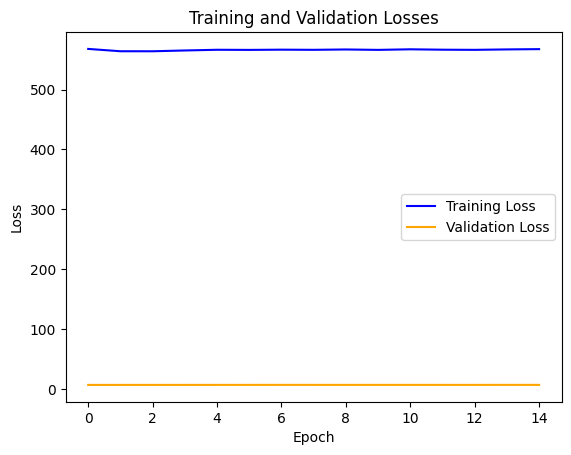

In [72]:
# Calculate the number of epochs (assuming the lengths of train_losses and val_losses are equal)
num_epochs = len(Train_losses)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the training losses
ax.plot(range(num_epochs), Train_losses, label='Training Loss', color='blue')

# Plot the validation losses
ax.plot(range(num_epochs), Val_losses, label='Validation Loss', color='orange')

# Set the x-axis label
ax.set_xlabel('Epoch')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('Training and Validation Losses')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

![loss_gpt.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/V1Fda63Q4CrNfgT5g1HfVQ.png)


## Loading the saved model
If you want to skip training and load a trained model that we provided, go ahead and uncomment the following cell:


In [77]:
#!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kyn1_OsXrzjef0xihlsXmg.pt'
#model.load_state_dict(torch.load('kyn1_OsXrzjef0xihlsXmg.pt',map_location=torch.device('cpu')))

In [81]:
print(generate(model,prompt="the movie was",max_new_tokens=10,vocab=vocab,tokenizer=tokenizer))

shivam amble projector/ray terrell syndication raffles lloyd bottomline hanks-philes daffily


You can see that the result is not satisfactory, which is due to the fact that LLMs need to be trained on huge data for several epochs to be accurate.


## Loading GPT2 model from HuggingFace
Let's now load the GPT2 model from HuggingFace to check how it performs at text generation:


In [79]:
# Load the tokenizer and model
tokenizer1 = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define the input prompt
#input_text = "Once upon a time in a faraway land,"
input_text = "the movie was"

# Tokenize the input text and prepare the input for the model
input_ids = tokenizer1.encode(input_text, return_tensors="pt")

# Generate text using the model
# Set the desired length of the generated text (max_length),
# and other generation parameters like temperature, top_k, and top_p
max_length = 15
temperature = 0.7
top_k = 50
top_p = 0.95

generated_ids = model.generate(
    input_ids,
    max_length=max_length,
    temperature=temperature,
    top_k=top_k,
    top_p=top_p,
    pad_token_id=tokenizer1.eos_token_id,
)

# Decode the generated text
generated_text = tokenizer1.decode(generated_ids[0], skip_special_tokens=True)

# Print the input prompt and the generated text
print(f"Input: {input_text}")
print(f"Generated Text: {generated_text}")

Input: the movie was
Generated Text: the movie was a bit of a disappointment, but it was a great movie


## Exercise: Creating a decoder model
In this exercise, you will create an instance of GPT-like model and prompt it to generate text. To achieve this, you will leverage the same GPT model discussed previously and make necessary modifications.

1. **Create an instance with the following parameters:**
   - `embedding size` = 200
   -  `number of layers` = 2
   -  `number of attention heads` = 2
   -  `dropout probability` = 0.2

2. **Create a prompt**

3. **Pass the prompt to model to generate text with a maximum length of 15**


In [80]:
#Write your code here

ntokens = len(vocab)  
emsize = 200 
nlayers = 2  
nhead = 2
dropout = 0.2  




print(generate(model,prompt="spring is",max_new_tokens=15,vocab=vocab,tokenizer=tokenizer))



200
ambitious tableware desolate campfire goût poor-choice existience restriction ---> shanao are goksal hone stocking pepin


<details>
    <summary>Click here for Solution</summary>

```python

ntokens = len(vocab)  
emsize = 200 
nlayers = 2  
nhead = 2
dropout = 0.2  


model = CustomGPTModel(embed_size=emsize, num_heads=nhead, num_layers=nlayers, vocab_size=ntokens,dropout=dropout).to(DEVICE)


print(generate(model,prompt="spring is",max_new_tokens=15,vocab=vocab,tokenizer=tokenizer))
```

</details>


# Congratulations! You have completed the lab

## Authors

[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.

## References
[Causal Language Modeling](https://huggingface.co/docs/transformers/en/tasks/language_modeling) PyTorch tutorial

© Copyright IBM Corporation. All rights reserved.
